<a href="https://colab.research.google.com/github/MarinaLima/IA/blob/master/Google_Brain_Ventilator_Pressure_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# importando bibliotecas importantes
import pandas as pd
import matplotlib.pyplot as plt

# Definição do problema a ser resolvido

O objetivo deste trabalho é desenvolver ao longo da disciplina de Mineração de Dados uma solução para o desafio [Google Brain - Ventilator Pressure Prediction](https://www.kaggle.com/competitions/ventilator-pressure-prediction/data?select=sample_submission.csv). Para isso será apresentada uma abordagem de estudo, em que através de modelos previamente estabelecidos e algoritmos de aprendizado de máquina, será possível prever a pressão das vias aereas no circuito respiratório durante a respiração, dadas as séries temporais de entradas de controle.

Quando um paciente tem dificuldade para respirar, os médicos utilizam um ventilador para bombear oxigênio para os pulmões de um paciente sedado por meio de um tubo na traqueia. Mas a ventilação mecânica é um procedimento clínico intensivo, uma limitação que foi exibida com destaque durante os primeiros dias da pandemia de COVID-19. Ao mesmo tempo, desenvolver novos métodos para controlar ventiladores mecânicos é proibitivamente caro e simuladores de alta qualidade podem reduzir essa barreira.

Os simuladores atuais são treinados como um conjunto, onde cada modelo simula uma única configuração de pulmão. No entanto, os pulmões e seus atributos formam um espaço contínuo, portanto, uma abordagem paramétrica que considere as diferenças nos pulmões dos pacientes deve ser explorada que.

Em parceria com a Universidade de Princeton, a equipe do Google Brain visa aumentar a comunidade em torno do aprendizado de máquina para controle de ventilação mecânica. Eles acreditam que as redes neurais e o aprendizado profundo podem generalizar melhor os pulmões com características variadas do que o padrão atual da indústria de controladores PID.

Um bom resultado nessa simulação pode ajudar a superar a barreira de custo do desenvolvimento de novos métodos para controlar ventiladores mecânicos. Abrindo caminho para algoritmos que se adaptam aos pacientes e reduzem a carga dos médicos durante esses novos tempos. Como resultado, os tratamentos com ventiladores podem se tornar mais amplamente disponíveis para ajudar os pacientes a respirar.

Além dos fatos já citado, uma outra motivação para escolha desse desafio em específico é o fato de eu ser dependente da ventilação mecânica não invasiva no meu dia a dia. Apesar desse trabalho focar em ventilação mecânica invasica, considerando que os pacientes estão sedados, bons resultados podem me beneficiar diretamente. 




# Análise dos dados

Os dados de entrada são compostos por séries temporais, onde cada série representa uma respiração de aproximadamente 3 segundos. Os arquivos são organizados de forma que cada linha seja um intervalo de tempo em uma respiração e forneça os dois sinais de controle, a pressão resultante nas vias aéreas e os atributos relevantes do pulmão, conforme descrito abaixo:

*  id: identificador de intervalo de tempo globalmente exclusivo em um arquivo inteiro.

* breath_id: intervalo de tempo globalmente exclusivo para respirações.

* R: atributo do pulmão que indica o quão restrita é a via aérea (em cmH2O/L/S). Fisicamente, esta é a mudança na pressão por mudança no fluxo (volume de ar por tempo). Intuitivamente, pode-se imaginar encher um balão com um canudo. Podemos alterar R alterando o diâmetro do canudo, com R maior sendo mais difícil de soprar.

* C: atributo do pulmão que indica a complacência do pulmão (em mL/cmH2O). Fisicamente, esta é a mudança de volume por mudança de pressão. Intuitivamente, pode-se imaginar o mesmo exemplo de balão. Podemos alterar C alterando a espessura do látex do balão, com C mais alto tendo látex mais fino e mais fácil de soprar.

* time_step: o carimbo de hora real.

* u_in:  a entrada de controle para a válvula solenoide inspiratória. Varia de 0 a 100 % onde, 0 é completamente fechado e nenhum ar entra e 100 é completamente aberto.

* u_out: a entrada de controle para a válvula solenoide exploratória. Se a válvula exploratória está aberta (1) ou fechada (0) para deixar o ar sair. 

* pressure: a pressão nas vias aéreas medida no circuito respiratório, medida em cmH2O.

Dentre as variáveis conseguimos separá-las nas seguintes categorias:

* Categóricas ordinais: R e C
* Categórica binária: u_out
* Numéricas contínuas: u_in e pressure



In [10]:
# lendo os dados
train_data = pd.read_csv ('train.csv')
test_data = pd.read_csv ('test.csv')

print(train_data)

          id  breath_id   R     C  time_step       u_in  u_out   pressure
0          1          1  20  50.0   0.000000   0.083334    0.0   5.837492
1          2          1  20  50.0   0.033652  18.383041    0.0   5.907794
2          3          1  20  50.0   0.067514  22.509278    0.0   7.876254
3          4          1  20  50.0   0.101542  22.808822    0.0  11.742872
4          5          1  20  50.0   0.135756  25.355850    0.0  12.234987
...      ...        ...  ..   ...        ...        ...    ...        ...
15449  15450        283  20  50.0   0.309130   0.975546    0.0   9.633808
15450  15451        283  20  50.0   0.343173  12.525554    0.0   9.844714
15451  15452        283  20  50.0   0.377175  23.403273    0.0  11.883476
15452  15453        283  20  50.0   0.412125  30.654660    0.0  15.187677
15453  15454        283  20   NaN        NaN        NaN    NaN        NaN

[15454 rows x 8 columns]


Valor nulo nos dados:

 id           0
breath_id    0
R            0
C            1
time_step    1
u_in         1
u_out        1
pressure     1
dtype: int64


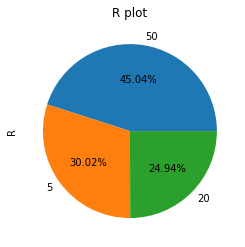

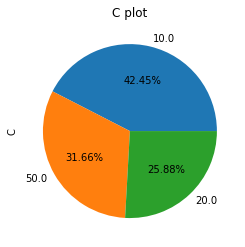

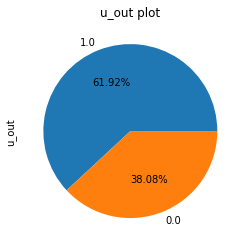

In [25]:
# verifica cada um dos atributos para valores nulos

print("Valor nulo nos dados:\n\n", train_data.isna().sum())

# separa dados categóricos para visualização
category_data = train_data[['R', 'C', 'u_out']]
for column in category_data.columns:
  b_plot = train_data[column].value_counts()
  b_plot.plot(kind='pie', autopct='%1.2f%%')
  plt.title(column + ' plot')
  plt.show()

# variáveis numéricas
# boxplot não trás informações relevantes

# num_data = train_data.columns.difference(category_data.columns)
# num_data = train_data[num_data]

# for column in num_data.columns:
#   b_plot = num_data.boxplot(column=column)
#   b_plot.plot() 
#   plt.title(column + ' boxplot')
#   plt.show()